### ENGC63 - Processamento Digital de Sinais
## Projeto de Filtros

<b>Filtros</b> são sistemas que selecionam ou modificam certas frequências de um sinal de entrada. Eles podem ser seletivos em frequência, passando apenas certas frequências e rejeitando outras, ou podem modificar frequências de maneira mais geral.

O projeto de filtros de tempo discreto envolve determinar os parâmetros de uma <b>função de transferência</b> ou <b>equação de diferenças</b> que aproxima uma resposta ao impulso ou em frequência dentro de tolerâncias especificadas. Existem duas categorias principais: <b>filtros com resposta ao impulso infinita (IIR)</b> e <b>filtros com resposta ao impulso finita (FIR)</b>. O projeto de filtros IIR envolve obter uma função de transferência racional, enquanto o projeto de filtros FIR resulta em uma aproximação polinomial. As técnicas de projeto para essas duas classes são diferentes.

O seguinte relatório demonstra a implementação de um <b>filtro passa-baixas FIR</b> utilizando o <b>método de janelamento</b>, mais especificamente a <b>janela de Kaiser</b>.  

### Método de Janelamento

Muitos sistemas idealizados têm respostas em frequência que são constantes ou suaves por partes, com descontinuidades nas extremidades. Isso resulta em respostas ao impulso que são não causais e infinitamente longas. Para aproximar esses sistemas com <b>filtros FIR</b>, o método mais direto é *truncar* a resposta ao impulso ideal usando o <b>processo de janelamento</b>.

Considera-se um <b>filtro passa-baixas ideal</b> com fase linear do tipo:

$$
H_d(e^{j\omega}) = 
\begin{cases} 
e^{-j\omega n_d}, & |ω| ≤ ω_c \\
0, & ω_c < |ω| ≤ π 
\end{cases}
$$

Tal sistema possui a seguinte resposta ao impulso:

$$
h_d[n] = \frac{\sin(ω_c(n − n_d))}{π(n − n_d)}, \quad -∞ < n < ∞
$$

Verifica-se que a resposta ao impulso possui <b>duração infinita</b> e é <b>não causal</b>. Uma maneira mais usual de obter um filtro FIR causal a partir de $h_d[n]$ consiste em *truncar* $h_d[n]$, isto é, definir um novo sistema com resposta ao impulso $h[n]$ dada por:

$$
h[n] =
\begin{cases} 
h_d[n], & 0 ≤ n ≤ M \\
0, & caso\;contrário 
\end{cases}
$$

Isto é equivalente a multiplicar a resposta ao impulso tideal $h_d[n]$ por uma janela de duração finita $w[n]$:

$$
h[n] = h_d[n] · w[n]
$$

E, tem-se que, $w[n]$ representa uma <b>janela retangular</b> para um truncamento simples:

$$
w[n] =
\begin{cases} 
1, & 0 ≤ n ≤ M
0, & caso\;contrário 
\end{cases}
$$

Assim, pelo teorema da modulação:

$$
H(e^{j\omega}) = \frac{1}{2\pi}\int_{-\pi}^{\pi} H_d(e^{j\theta})W(e^{j(\omega-\theta)}) \,d\theta
$$

onde $H(e^{j\omega})$ é a convolução periódica da resposta ideal desejada $H_d(e^{j\omega})$ com a <b>transformada de Fourier</b> da janela. Isso faz com que $H(e^{j\omega})$ seja uma versão “espalhada” de $H_d(e^{j\omega})$. Se não houver truncamento (ou seja, $w[n] = 1$ para todo $n$), $W(e^{j\omega})$ será um trem de impulsos periódico, e $H(e^{j\omega}) = H_d(e^{j\omega})$.

Para que $H(e^{j\omega})$ se aproxime de $H_d(e^{j\omega})$, a janela $w[n]$ deve ser escolhida de modo que $W(e^{j\omega})$ esteja concentrado em uma faixa estreita de frequências em torno de $\omega = 0$. Isso minimiza os cálculos e garante que a convolução reproduza fielmente a resposta em frequência desejada.


### Janela de Kaiser

A janela de Kaiser é definida como:

$$
w[n] = 
\begin{cases} 
\frac{I_0\left(\beta \sqrt{1 - \left(\frac{n - \alpha}{\alpha}\right)^2}\right)}{I_0(\beta)}, & 0 \leq n \leq M, \\
0, & \text{caso contrário},
\end{cases}
$$

onde:

- \( $\beta$ \) é o parâmetro da janela de Kaiser, que controla o trade-off entre a largura da banda de transição e a atenuação da banda de rejeição.
- \( $\alpha$ \) é dado por \( $\alpha = \frac{M}{2}$ \), onde \( M \) é a ordem do filtro.
- \( $I_0$ \) é a função modificada de Bessel de primeira espécie e ordem zero.

Ao contrário de outras janelas, a de Kaiser tem dois parâmetros: o comprimento (M + 1)
e o parâmetro de forma β. Variando-se (M + 1) e β, o comprimento da janela e sua forma podem ser ajustados para trocar amplitude do lóbulo lateral por largura do lóbulo principal.

Pela equação vemos que o caso β = 0 se reduz à janela retangular.


In [46]:
import numpy as np
from numpy import pi, sinc, arange, log10
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import signal, fft
from scipy.signal import firwin, kaiserord, freqz, tf2sos, sosfreqz
from scipy.signal.windows import kaiser
from utils import plot_impulse_response, plot_frequency_response_direct, plot_frequency_response, plot_approximation_error, plot_phase_response, plot_group_delay


### Especificação do Filtro

O filtro passa-baixas FIR deve ter uma <b>frequência de corte</b> de $\omega_c = \frac{\pi}{2}$, uma <b>atenuação mínima</b> na banda de rejeição $\geq 50dB$ e uma região de transição $\Delta\omega = \omega_s - \omega_p < 0,1\pi$

In [47]:
# Parâmetros do problema
fs = 2                      # Frequência de amostragem (normalizada)
wc = pi / 2                 # Frequência de corte em radianos
cutoff = wc / pi            # Frequência de corte normalizada

attenuation = 50            # Atenuação mínima na banda rejeitada em dB
transition_width = 0.1      # Largura da banda de transição em (normalizada em π radianos)

## Método direto

#### Filtro passa-baixas com firwin

In [48]:
# Calculando a ordem do filtro e o parâmetro beta da janela de Kaiser
M, beta = kaiserord(ripple=attenuation,
                    width=transition_width)

# Projetando o filtro FIR utilizando a função firwin e a janela de Kaiser
filter_h = firwin(numtaps=M,
                  cutoff=cutoff,
                  window=('kaiser', beta),
                  pass_zero='lowpass')

# Resposta em frequência
w, h = freqz(b=filter_h, worN=8000)

print(f"M = {M}")
print(f"beta = {beta}")

M = 60
beta = 4.533514120981248


### Plots

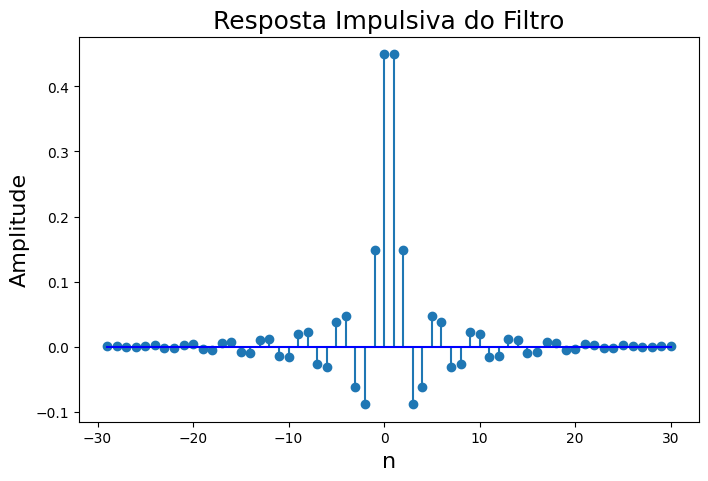

In [49]:
plot_impulse_response(M, filter_h)

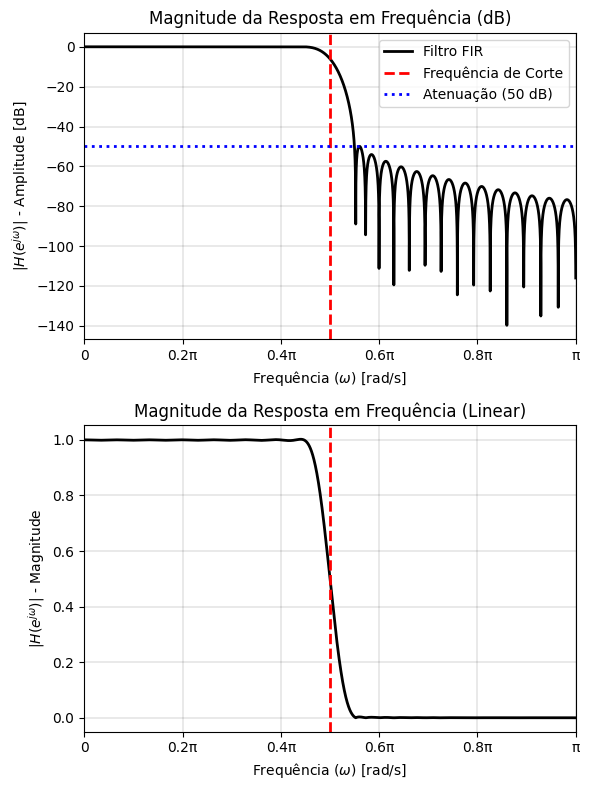

In [50]:
plot_frequency_response(w, h, wc, attenuation)

In [ ]:
def plot_group_delay(w, group_delay, fig=None, axs=None, color="black", legend=None):
    if fig is None or axs is None:
        fig, axs = plt.subplots(figsize=(6, 4))

    axs.plot(w / np.pi, group_delay, color=color, linewidth=2.0, linestyle='-', label=legend)
    axs.set_xlim(0, 1)
    axs.set_title('Atraso de Grupo')
    axs.set_xlabel(r"Frequência Normalizada ($\omega$) [$\pi$ rad/s]")
    axs.set_ylabel('Atraso de Grupo [s]')
    axs.grid(True, which='both', linestyle='-', linewidth=0.2, alpha=0.6, color='black')
    axs.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ['0', '0.2π', '0.4π', '0.6π', '0.8π', 'π'])

    if legend is not None:
        axs.legend()

    plt.tight_layout()
    return axs

d:\Code\Projetos\FIR_Filter_WindowMethod\notebook\utils.py:74: RuntimeWarning: divide by zero encountered in log10
  error = 20 * np.log10(np.abs(desired_response - h))


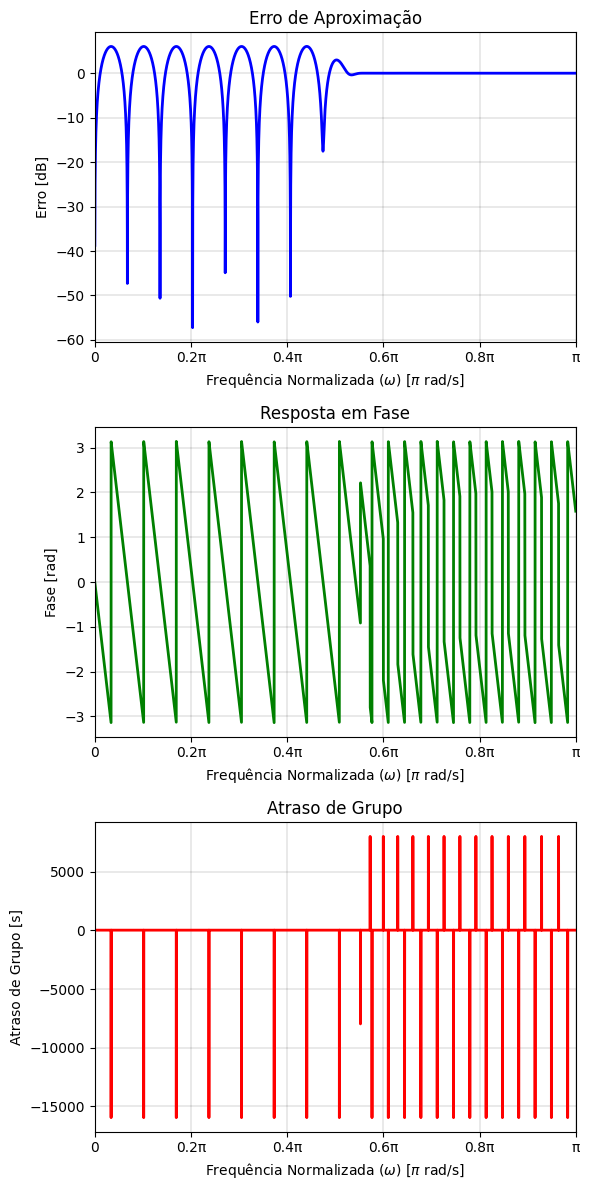

In [51]:
# Exemplo de uso das funções
fig, axs = plt.subplots(3, 1, figsize=(6, 12))

desired_response = np.ones_like(h)  # Resposta desejada ideal (exemplo)

# Plotando os gráficos
plot_approximation_error(w, h, desired_response, fig=fig, axs=axs[0], color='blue')
plot_phase_response(w, h, fig=fig, axs=axs[1], color='green',)
plot_group_delay(w, h, fig=fig, axs=axs[2], color='red')

plt.tight_layout()
plt.show()


### Filtro feito com menos funções auxiliares com o mesmo resultado

In [52]:
# Definir parâmetros do filtro
As = 50  # Atenuação mínima na banda de rejeição (dB)
delta_w = 0.1 * np.pi  # Largura de transição

# Calcular o parâmetro beta_kaiser da janela de Kaiser
beta_kaiser = 0
if As > 50:
    beta_kaiser = 0.1102 * (As - 8.7)
elif As >= 21:
    beta_kaiser = 0.5842 * (As - 21)**0.4 + 0.07886 * (As - 21)

# Calcular o comprimento do filtro
N_kaiser = int(np.ceil((As - 8) / (2.285 * delta_w))) + 1
if N_kaiser % 2 == 0:
    N_kaiser += 1  # Certifique-se de que N_kaiser seja ímpar

# Gerar a resposta ao impulso do filtro ideal (sinc function)
n_kaiser = np.arange(N_kaiser)
h_kaiser = np.sinc((n_kaiser - (N_kaiser - 1) / 2) * wc / np.pi)

# Aplicar a janela de Kaiser
window = kaiser(N_kaiser, beta_kaiser)
h_kaiser = h_kaiser * window

# Normalizar o filtro
h_kaiser /= np.sum(h_kaiser)

w_kaiser, H_kaiser = freqz(h_kaiser, worN=8000)

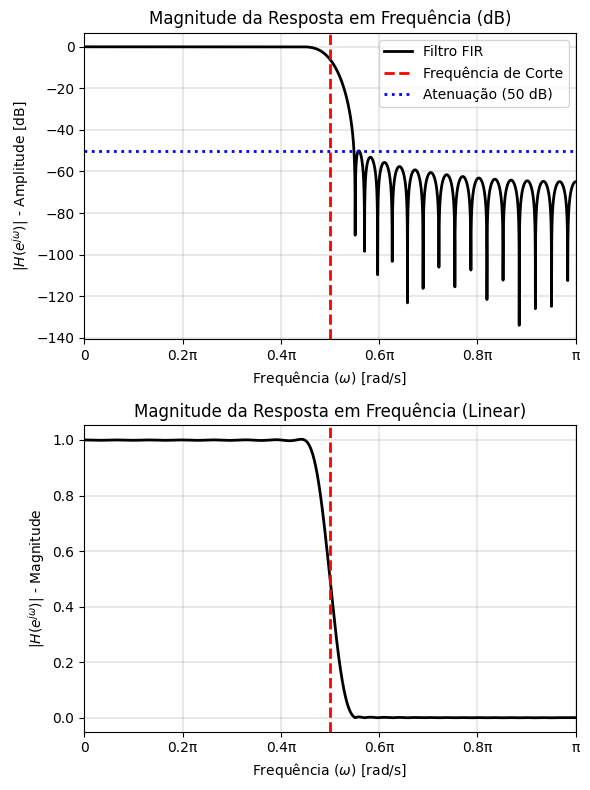

In [53]:
axs = plot_frequency_response(w_kaiser, H_kaiser, wc, attenuation)
# fig.suptitle("Resposta em frequência - Forma direta")

### TO DO: não consgui fazer esse grafico ficar com as cores bonitinhas nos trechos certos que eu vi na net

In [54]:
# w = w / np.pi  # Normalizar para frequência em múltiplos de π

# # Parâmetros de plotagem
# fpass = cutoff
# fstop = fpass + transition_width
# ymin, ymax = -80, 5

# # Criar o gráfico
# fig, ax = plt.subplots()
# fig.set_size_inches((8, 3))

# ax.plot(w * fs / 2., 20 * np.log10(abs(H)), label='Resposta em Frequência')
# ax.set_xlabel("Frequência (Hz)", fontsize=16)
# ax.set_ylabel("Magnitude (dB)", fontsize=22)
# ax.axis([0, fs / 2, ymin, ymax])

# # Adicionar áreas de banda de passagem e rejeição
# ax.add_patch(plt.Rectangle((0, ymin), width=fpass, height=ymax-ymin, color='g', alpha=0.3))
# ax.add_patch(plt.Rectangle((fpass, ymin), width=fstop-fpass, height=ymax-ymin, color='r', alpha=0.3))
# ax.add_patch(plt.Rectangle((fstop, ymin), width=fs/2-fstop, height=ymax-ymin, color='y', alpha=0.3))

# # Adicionar título e legendas
# ax.set_title(f"Número de taps = {M}", fontsize=16)
# ax.text(0.05, -15, 'Banda de Passagem', fontsize=14, bbox=dict(color='white'))
# ax.text(fpass + 0.05, -15, 'Banda de Rejeição', fontsize=16, bbox=dict(color='white'))
# ax.grid()
# ax.legend()

# # Mostrar o gráfico
# plt.show()

## Cascata

Para converter o filtro FIR para a forma em cascata e utilizar tf2sos para obter os coeficientes, você pode seguir estes passos:

* Transformar o filtro FIR em uma representação em cascata:
    * A função tf2sos pode ser utilizada para converter a representação de um filtro em formato de coeficientes de numerador e denominador para uma forma em cascata.
* Aplicar os subfiltros em cascata e plotar a resposta em frequência:
    * Divida o filtro FIR em uma série de filtros em cascata e aplique cada filtro na sequência.

In [55]:
# O filtro FIR pode ser considerado como um filtro IIR com coeficientes denominadores iguais a 1
sos = tf2sos(filter_h, [1.0])  # Convertendo para a forma de seções de segundo ordem

# Resposta em frequência para o filtro em cascata
w_cascade, H_cascade = sosfreqz(sos, worN=8000)

n = np.arange(len(filter_h))

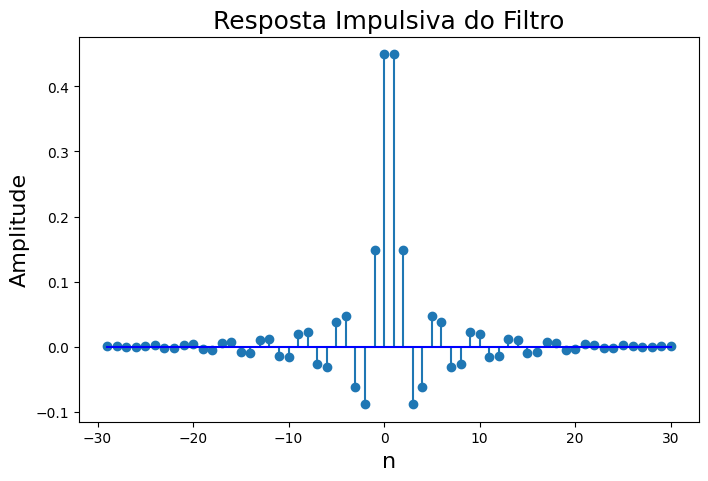

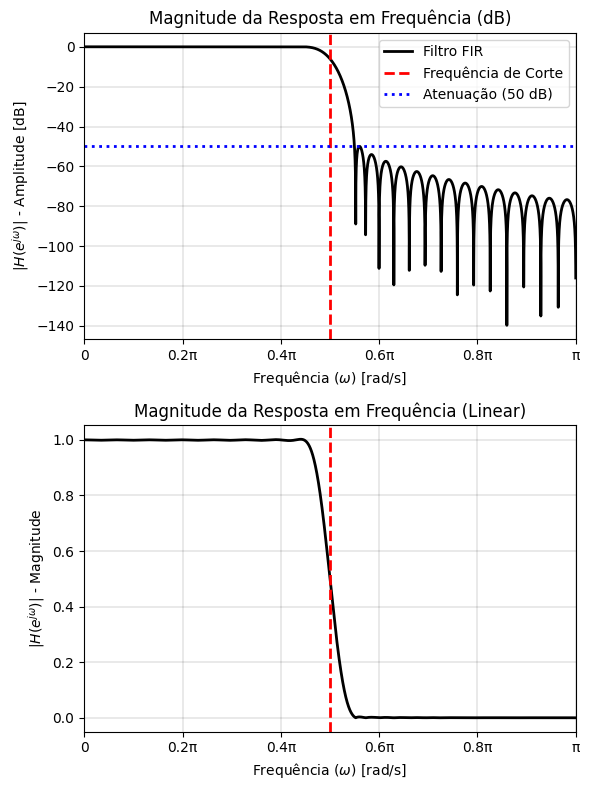

In [56]:
plot_impulse_response(M, filter_h)
plot_frequency_response(w_cascade, H_cascade, wc, attenuation)

In [57]:
# # Plotando os gráficos
# fig, axs = plt.subplots(3, 1, figsize=(8, 12))
# plt.subplots_adjust(hspace=0.8)

# # Resposta impulsiva do filtro
# ax = axs[0]
# ax.stem(n - (M - 1) // 2, h, basefmt='b-', label='Filtro Direto')
# ax.set_xlabel("n", fontsize=16)
# ax.set_ylabel("Amplitude", fontsize=16)
# ax.set_title("Resposta Impulsiva do Filtro", fontsize=18)
# ax.legend()

# # Magnitude da resposta em frequência
# ax = axs[1]
# ax.plot(w * np.pi, abs(H), label='Filtro Direto')
# ax.plot(w_cascade * np.pi, abs(H_cascade), label='Filtro em Cascata', linestyle='--')
# ax.vlines([wc], 0, 1.2 * max(np.max(abs(H)), np.max(abs(H_cascade))), color='g', lw=2., linestyle='--')
# ax.hlines(1, -np.pi, np.pi, color='g', lw=2., linestyle='--')
# ax.set_xlabel(r"$\omega$", fontsize=22)
# ax.set_ylabel(r"$|H(\omega)|$", fontsize=22)
# ax.set_title("Magnitude de Resposta em Frequência", fontsize=18)
# ax.grid()
# ax.legend()

# # Resposta em frequência em dB
# ax = axs[2]
# ax.plot(w * np.pi, 20 * np.log10(abs(H)), label='Filtro Direto')
# ax.plot(w_cascade * np.pi, 20 * np.log10(abs(H_cascade)), label='Filtro em Cascata', linestyle='--')
# ax.vlines([wc], -60, 5, color='g', lw=2., linestyle='--')
# ax.hlines(0, -np.pi, np.pi, color='g', lw=2., linestyle='--')
# ax.set_xlabel(r"$\omega$", fontsize=22)
# ax.set_ylabel(r"$20\log_{10}|H(\omega)|$", fontsize=18)
# ax.set_title("Resposta em Frequência em dB", fontsize=18)
# ax.grid()
# ax.legend()

# plt.show()

## Diminuindo o número de casas decimais

In [58]:
# Função para quantizar coeficientes
def quantize_coefficients(coefficients, decimals):
    return np.round(coefficients, decimals)

# Níveis de quantização a serem testados
quantization_levels = [6, 5, 4, 3, 2, 1]

### Forma direta

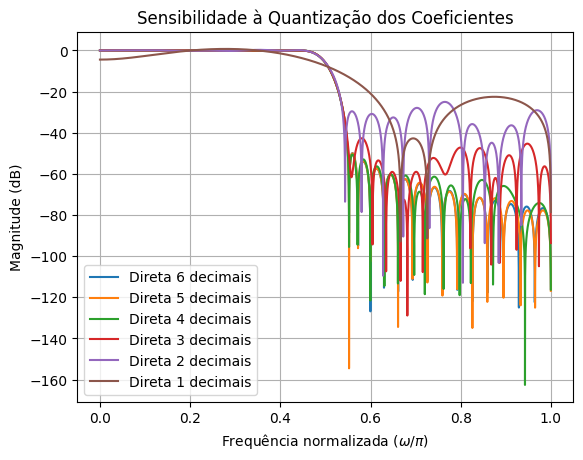

In [59]:
plt.figure()

for decimals in quantization_levels:
    # Quantizando os coeficientes
    h_quantized = quantize_coefficients(filter_h, decimals)
    
    # Resposta em frequência da forma direta (FIR quantizado)
    w_direct, H_direct = signal.freqz(h_quantized, worN=8000)
    
    # Plotando a resposta em frequência
    plt.plot(w_direct / np.pi, 20 * np.log10(np.abs(H_direct)), label=f'Direta {decimals} decimais')

# Configurações do gráfico
plt.xlabel('Frequência normalizada ($\omega/\pi$)')
plt.ylabel('Magnitude (dB)')
plt.title('Sensibilidade à Quantização dos Coeficientes')
plt.legend()
plt.grid(True)
plt.show()


### Forma em cascata

d:\Code\Projetos\FIR_Filter_WindowMethod\.venv\Lib\site-packages\scipy\signal\_filter_design.py:1112: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  b, a = normalize(b, a)


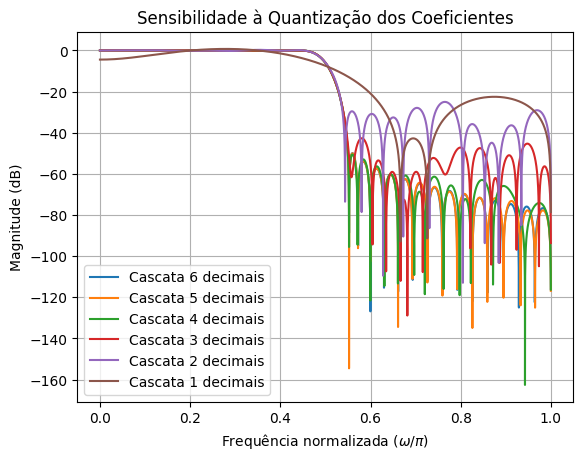

In [60]:
for decimals in quantization_levels:
    # Quantizando os coeficientes
    h_quantized = quantize_coefficients(filter_h, decimals)
    
    # Convertendo para a forma de seções de segunda ordem (cascata)
    sos_quantized = signal.tf2sos(h_quantized, [1.0])
    
    # Resposta em frequência da forma em cascata (FIR quantizado)
    w_cascade, H_cascade = signal.sosfreqz(sos_quantized, worN=8000)
    
    # Plotando a resposta em frequência
    plt.plot(w_cascade / np.pi, 20 * np.log10(np.abs(H_cascade)), linestyle='-', label=f'Cascata {decimals} decimais')

# Configurações do gráfico
plt.xlabel('Frequência normalizada ($\omega/\pi$)')
plt.ylabel('Magnitude (dB)')
plt.title('Sensibilidade à Quantização dos Coeficientes')
plt.legend()
plt.grid(True)
plt.show()